# Link Prediction using DGL

This notebook uses the Python Library DGL for friend recommendation. 

Some of the code is adapted from the following tutorial for link prediction: https://docs.dgl.ai/en/0.6.x/tutorials/blitz/4_link_predict.html#sphx-glr-tutorials-blitz-4-link-predict-py

In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import itertools
import numpy as np
import scipy.sparse as sp
from time import time
import pandas as pd
import dgl
import os

## Dataset Loading

We use the [Facebook social circles](https://snap.stanford.edu/data/ego-Facebook.html) dataset, available at the Stanford SNAP website, for friend recommendation.


Obviously, we need to load the friendship (edges) into the graph. The files also provide user features information, represented by a 224-dimensional vector of 0s and 1s, so we load that as well. For the simplicity of this tutorial, we will only use one ego network (e.g. User 0's network).

In [2]:
def get_user(x):
    return x[0]

user_data = pd.Series(np.char.split(np.array(os.listdir('./facebook_data')), sep='.'))
user_ls = np.unique(np.array(user_data.apply(get_user)))
user_ls

array(['0', '107', '1684', '1912', '3437', '348', '3980', '414', '686',
       '698'], dtype=object)

In [4]:
# user id, which correspond to file name prefix
USER = 0

file_edges = f'facebook_data/{USER}.edges'
file_feat = f'facebook_data/{USER}.feat'

edges_u, edges_v = [], []

with open(file_edges) as f:  # load edges file
    for line in f:
        e1, e2 = tuple(int(x) - 1 for x in line.split())
        edges_u.append(e1)
        edges_v.append(e2)

edges_u, edges_v = np.array(edges_u), np.array(edges_v)

num_nodes = 0  # assumes nodes are sequential
feats = []  # node features

with open(file_feat) as f:  # load node features file
    for line in f:
        num_nodes += 1
        a = [int(x) for x in line.split()[1:]]  # 0th entry is node id
        feats.append(torch.tensor(a, dtype=torch.float))

feats = torch.stack(feats)
# print(feats.shape)

g = dgl.graph((edges_u, edges_v))  # construct graph
g.ndata['feat'] = feats

g

Graph(num_nodes=347, num_edges=5038,
      ndata_schemes={'feat': Scheme(shape=(224,), dtype=torch.float32)}
      edata_schemes={})

## Graph Visualization

We use the networkx library for visualizing the friendship relationships. There are hundreds of nodes (not shown), and thousands of links, so it can seem a bit messy when the graph is drawn.

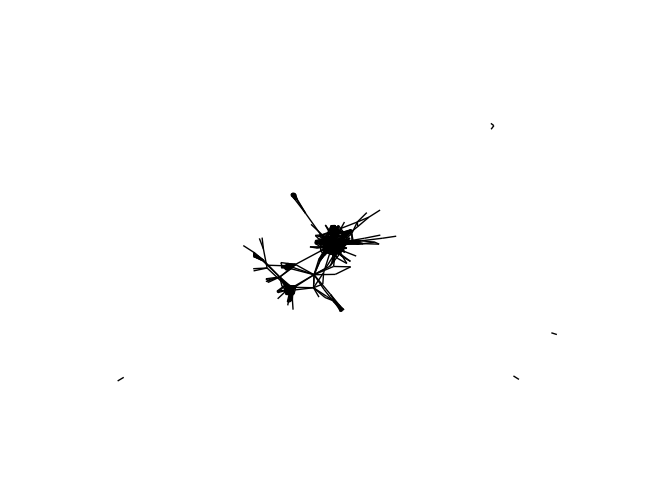

In [5]:
import networkx as nx

G = nx.Graph()
G.add_nodes_from(set(edges_u + edges_v))
G.add_edges_from(zip(edges_u, edges_v))

nx.draw(G, node_size=0)

## Training/testing data construction

Once we have the graph constructed, we can split it into the training set and testing set. We omit the validation set for simplicity.

We construct a graph of "negative edges"; whenever there is a lack of an edges between two nodes `u` and `v` in the original graph, there is a corresponding edge in the negative graph. This is needed for telling the training algorithm what the "negative examples" are.

We randomly split 30% of links for testing, and leave 70% for training. 

In [6]:
TEST_RATIO = 0.3  # ratio for splitting the test set

u, v = g.edges()

eids = np.arange(g.number_of_edges())
eids = np.random.permutation(eids)
test_size = int(len(eids) * TEST_RATIO)  # number of edges in test set
train_size = g.number_of_edges() - test_size  # number of edges in train set

# get positive edges for test and train
test_pos_u, test_pos_v = u[eids[:test_size]], v[eids[:test_size]]
train_pos_u, train_pos_v = u[eids[test_size:]], v[eids[test_size:]]

# Find all negative edges
adj = sp.coo_matrix((np.ones(len(u)), (u.numpy(), v.numpy())))
adj_neg = 1 - adj.todense() - np.eye(g.number_of_nodes())
neg_u, neg_v = np.where(adj_neg != 0)

# split the negative edges for training and testing 
neg_eids = np.random.choice(len(neg_u), g.number_of_edges())
test_neg_u, test_neg_v = neg_u[neg_eids[:test_size]], neg_v[neg_eids[:test_size]]
train_neg_u, train_neg_v = neg_u[neg_eids[test_size:]], neg_v[neg_eids[test_size:]]

# construct positive and negative graphs for training and testing
train_pos_g = dgl.graph((train_pos_u, train_pos_v), num_nodes=g.number_of_nodes())
train_neg_g = dgl.graph((train_neg_u, train_neg_v), num_nodes=g.number_of_nodes())

test_pos_g = dgl.graph((test_pos_u, test_pos_v), num_nodes=g.number_of_nodes())
test_neg_g = dgl.graph((test_neg_u, test_neg_v), num_nodes=g.number_of_nodes())

# training graph
train_g = dgl.remove_edges(g, eids[:test_size])
train_g = dgl.add_self_loop(train_g)

## Model definition

Here we build two models from the existing implementation in the DGL library. Both models consists of 2 convolutional layers. 

`GCN` is a standard graph convolutional network, and serves as a baseline. `GraphSAGE` is a more advanced and powerful network that we're testing.

We also define the `DotPredictor`, which helps to predict the likelihood of whether an edge exists or not, by taking the dot product of two nodes. 

In [7]:
from dgl.nn import SAGEConv
from dgl.nn import GraphConv

# ----------- create model -------------- #
# build an ordinary GCN model
class GCN(nn.Module):
    def __init__(self, in_feats, h_feats):
        super(GCN, self).__init__()
        self.conv1 = GraphConv(in_feats, h_feats)
        self.conv2 = GraphConv(h_feats, h_feats)

    def forward(self, g, in_feat):
        h = self.conv1(g, in_feat)
        h = F.relu(h)
        h = self.conv2(g, h)
        return h


# build a two-layer GraphSAGE model
class GraphSAGE(nn.Module):
    def __init__(self, in_feats, h_feats):
        super(GraphSAGE, self).__init__()
        self.conv1 = SAGEConv(in_feats, h_feats, 'mean')
        self.conv2 = SAGEConv(h_feats, h_feats, 'mean')

    def forward(self, g, in_feat):
        h = self.conv1(g, in_feat)
        h = F.relu(h)
        h = self.conv2(g, h)
        return h


import dgl.function as fn

class DotPredictor(nn.Module):
    def forward(self, g, h):
        with g.local_scope():
            g.ndata['h'] = h
            # Compute a new edge feature named 'score' by a dot-product between the
            # source node feature 'h' and destination node feature 'h'.
            g.apply_edges(fn.u_dot_v('h', 'h', 'score'))
            # u_dot_v returns a 1-element vector for each edge so you need to squeeze it.
            return g.edata['score'][:, 0]


## Training and testing pipeline

Here, we define a pipeline for training our model, and evaluating its performance.

For evaluation metric, we use AUC, which is explained in more detail in the blog post. 

---
Note: In the blog post, we mentioned using ranking-based metrics such as `HitRate@K`. However, such kind of metric cannot be used in our colab implementation, since we randomly split the testing edges from the training edges. This means that some users will not have an friend in the test set, and they will never receive a hit when measuring `HitRate@K`. To solve this, we could have tried to split our dataset in a better way, if given more time.

In [8]:
def pipeline(model_name='GCN', hidden_size=16):
    # model_name can be GCN or SAGE
    # hidden_size is the size of the hidden layer in the neural net
    if model_name == 'GCN':
        model = GCN(train_g.ndata['feat'].shape[1], hidden_size)
    elif model_name == 'SAGE':
        model = GraphSAGE(train_g.ndata['feat'].shape[1], hidden_size)
        
    pred = DotPredictor()

    def compute_loss(pos_score, neg_score):  # computes the loss based on binary cross entropy
        scores = torch.cat([pos_score, neg_score])
        labels = torch.cat([torch.ones(pos_score.shape[0]), torch.zeros(neg_score.shape[0])])
        return F.binary_cross_entropy_with_logits(scores, labels)

    def compute_auc(pos_score, neg_score):  # computes AUC (Area-Under-Curve) score
        scores = torch.cat([pos_score, neg_score]).numpy()
        labels = torch.cat(
            [torch.ones(pos_score.shape[0]), torch.zeros(neg_score.shape[0])]).numpy()
        return roc_auc_score(labels, scores)


    # ----------- set up loss and optimizer -------------- #
    # in this case, loss will in training loop
    optimizer = torch.optim.Adam(itertools.chain(model.parameters(), pred.parameters()), lr=0.01)

    # ----------- training -------------------------------- #
    all_logits = []
    for e in range(100):
        # forward
        h = model(train_g, train_g.ndata['feat'])  # get node embeddings
        pos_score = pred(train_pos_g, h)
        neg_score = pred(train_neg_g, h)
        loss = compute_loss(pos_score, neg_score)

        # backward
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if e % 5 == 0:
            print('In epoch {}, loss: {}'.format(e, loss))

    # ----------- test and check results ---------------- #
    from sklearn.metrics import roc_auc_score
    with torch.no_grad():
        pos_score = pred(test_pos_g, h)
        neg_score = pred(test_neg_g, h)
        print('AUC', compute_auc(pos_score, neg_score))
    
    return h  # return node embeddings


### Training and testing GCN:

In [9]:
h = pipeline("GCN")

In epoch 0, loss: 0.6642943024635315
In epoch 5, loss: 0.5544628500938416
In epoch 10, loss: 0.5119065642356873
In epoch 15, loss: 0.4895871877670288
In epoch 20, loss: 0.4737851619720459
In epoch 25, loss: 0.46935856342315674
In epoch 30, loss: 0.46504104137420654
In epoch 35, loss: 0.46093085408210754
In epoch 40, loss: 0.4562385380268097
In epoch 45, loss: 0.4520748555660248
In epoch 50, loss: 0.44810205698013306
In epoch 55, loss: 0.4442232847213745
In epoch 60, loss: 0.43980687856674194
In epoch 65, loss: 0.43471840023994446
In epoch 70, loss: 0.4292839765548706
In epoch 75, loss: 0.4244341552257538
In epoch 80, loss: 0.4202098250389099
In epoch 85, loss: 0.4156039357185364
In epoch 90, loss: 0.41111278533935547
In epoch 95, loss: 0.40703460574150085
AUC 0.9241814165784468


### Training and testing SAGE:

In [10]:
h = pipeline("SAGE")

In epoch 0, loss: 2.8630833625793457
In epoch 5, loss: 0.6810189485549927
In epoch 10, loss: 0.6799442172050476
In epoch 15, loss: 0.6654988527297974
In epoch 20, loss: 0.6325489282608032
In epoch 25, loss: 0.5962938070297241
In epoch 30, loss: 0.5709240436553955
In epoch 35, loss: 0.5537625551223755
In epoch 40, loss: 0.541768491268158
In epoch 45, loss: 0.5338500142097473
In epoch 50, loss: 0.5277358889579773
In epoch 55, loss: 0.5229325890541077
In epoch 60, loss: 0.5188815593719482
In epoch 65, loss: 0.5151752829551697
In epoch 70, loss: 0.5117619633674622
In epoch 75, loss: 0.5084309577941895
In epoch 80, loss: 0.5050894021987915
In epoch 85, loss: 0.5018646121025085
In epoch 90, loss: 0.49871936440467834
In epoch 95, loss: 0.49563631415367126
AUC 0.8679347261927861


# Friend recommendation

Once we trained our model, we can finally suggest friends. To do this, we calculate the embedding dot products between a given user and all other users that he/she is currently NOT friends with. Then we choose 5 users with the highest dot product scores to recommend to him/her.

In [11]:
# --------- generate recommendation for user -------- #
def generate_rec(h, user_id=0):
    # `h` represents the node embeddings, with shape [num_nodes, hidden_size]

    # generate a graph with (num_nodes - num_friends_of_user) edges
    # one end of the edge is user_id
    # the other end is a user that's NOT friends with user_id
    user_friends = set()
    user_neg_u, user_neg_v = [], []
    for n1, n2 in zip(u, v):   # get all friends of user_id
        if int(n1) == user_id:
            user_friends.add(int(n2))
        if int(n2) == user_id:
            user_friends.add(int(n1))

    for i in range(num_nodes):  # generate "negative edges" for user_id
        if i != user_id and i not in user_friends:
            user_neg_u.append(user_id)
            user_neg_v.append(i)
            
    user_g = dgl.graph((user_neg_u, user_neg_v), num_nodes=g.number_of_nodes())

    pred = DotPredictor()

    # calculate the score of each user
    scores = [(i, score) for i, score in enumerate(pred(user_g, h))]

    # produce final ranked list
    scores.sort(key=lambda x: -x[1])

    # display results
    print(f"List of 5 suggested friends for user {user_id}:")
    for i in range(5):
        print(f'- User {scores[i][0]}, score = {scores[i][1]}')


The recommended users are shown as follows:

In [14]:
generate_rec(h, user_id=0)

List of 5 suggested friends for user 0:
- User 274, score = 0.6301855444908142
- User 263, score = 0.6177087426185608
- User 114, score = 0.597420871257782
- User 43, score = 0.587447464466095
- User 321, score = 0.5793120861053467
